In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from wrappers import ResultWrapper

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 671993

In [2]:
df = pd.read_csv('../data/forbes_2000_cleaned_outliers_iqr_range.csv')

In [3]:
correlation = df.corr(method='spearman')
correlation

,market_value,profits,assets,sales,cost,rank,year
market_value,1.000000,0.376975,0.084847,0.145309,0.112915,-0.664675,0.147290
profits,0.376975,1.000000,-0.339543,0.263041,0.014670,-0.467502,-0.228596
assets,0.084847,-0.339543,1.000000,-0.033290,0.122086,-0.363497,0.408002
sales,0.145309,0.263041,-0.033290,1.000000,0.937285,-0.503753,-0.034235
cost,0.112915,0.014670,0.122086,0.937285,1.000000,-0.441264,0.072825
rank,-0.664675,-0.467502,-0.363497,-0.503753,-0.441264,1.000000,0.038209
year,0.147290,-0.228596,0.408002,-0.034235,0.072825,0.038209,1.000000


In [4]:
df['test'] = df.year == 2020

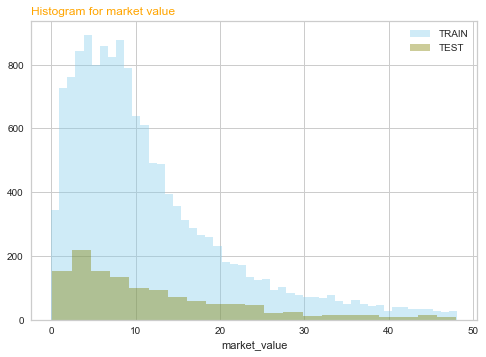

In [6]:
sns.distplot(
    a=df.loc[df.test == False, "market_value"],
    hist=True,
    kde=False,
    rug=False,
    color='skyblue',
    label='TRAIN'
)
sns.distplot(
    a=df.loc[df.test, "market_value"],
    hist=True,
    kde=False,
    rug=False,
    color='olive',
    label='TEST'
)
plt.title(
    f'Histogram for market value',
    loc='left',
    fontsize=12,
    fontweight=0,
    color='orange'
)
plt.legend()
plt.show()

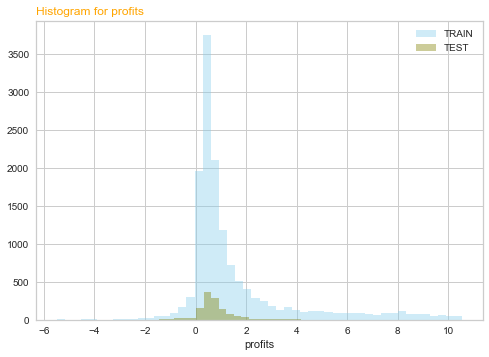

In [8]:
sns.distplot(
    a=df.loc[df.test == False, "profits"],
    hist=True,
    kde=False,
    rug=False,
    color='skyblue',
    label='TRAIN'
)
sns.distplot(
    a=df.loc[df.test, "profits"],
    hist=True,
    kde=False,
    rug=False,
    color='olive',
    label='TEST'
)
plt.title(
    f'Histogram for profits',
    loc='left',
    fontsize=12,
    fontweight=0,
    color='orange'
)
plt.legend()
plt.show()

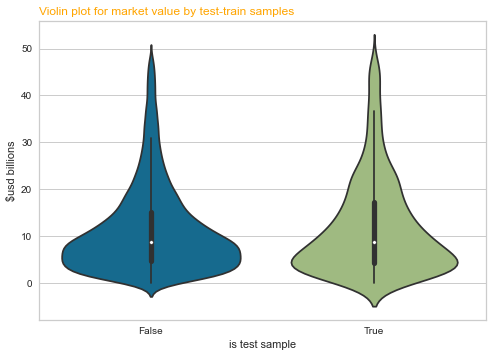

In [9]:
sns.violinplot(
    x=df["test"],
    y=df["market_value"]
)
plt.title(
    f'Violin plot for market value by test-train samples',
    loc='left',
    fontsize=12,
    fontweight=0,
    color='orange'
)
plt.xlabel('is test sample')
plt.ylabel('$usd billions')
plt.show()

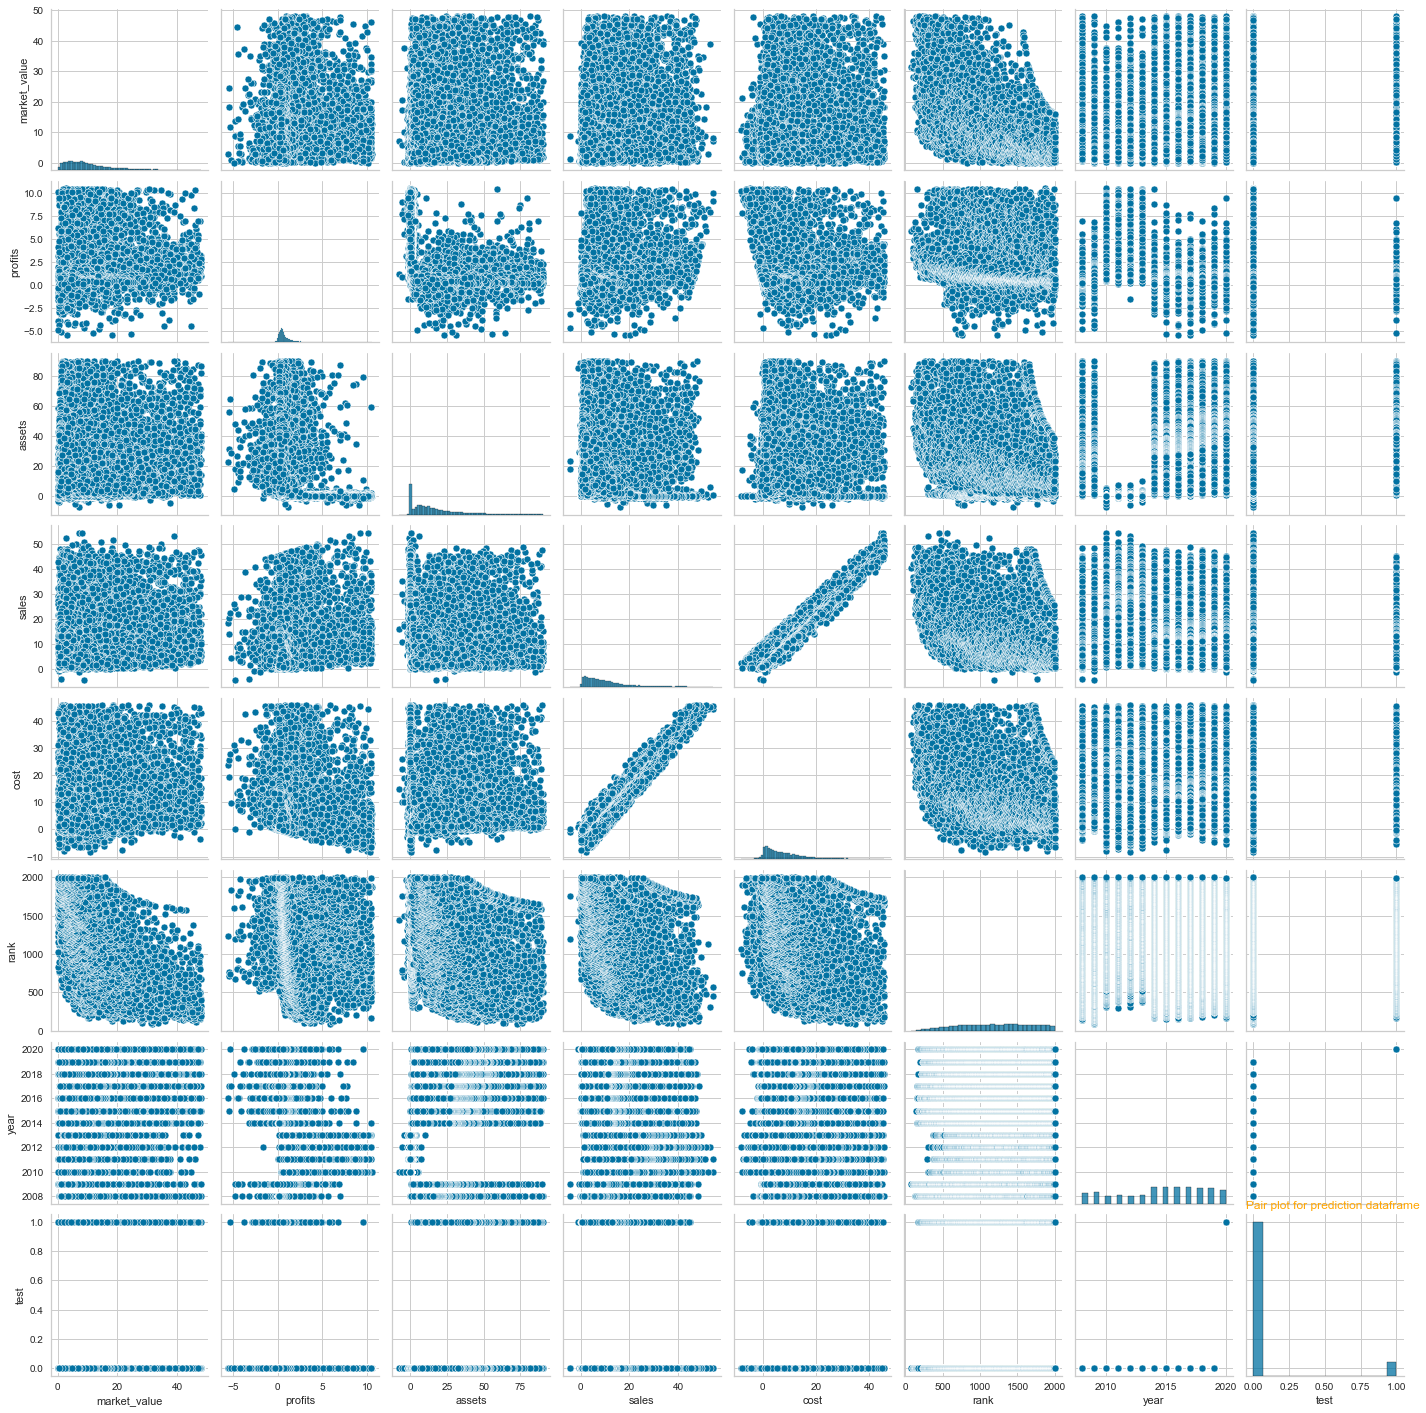

In [10]:
# Pair plot IQR dataframe
sns.pairplot(df)
plt.title(
    f'Pair plot for prediction dataframe',
    loc='left',
    fontsize=12,
    fontweight=0,
    color='orange'
)
plt.show()

In [11]:
def train_test_split_by_year(x_df: pd.DataFrame, y_df: pd.DataFrame):
    X_train = x_df[x_df.test == False].drop('test', axis=1).to_numpy()
    X_test = x_df[x_df.test].drop('test', axis=1).to_numpy()
    y_train = y_df[x_df.test == False].drop('test', axis=1).to_numpy().flatten()
    y_test = y_df[x_df.test].drop('test', axis=1).to_numpy().flatten()

    return X_train, X_test, y_train, y_test

In [30]:
# SIMPLE LINEAR REGRESSION (profits)

x=df.loc[:,['profits','test']]
y=df.loc[:,['market_value','test']]

X_train, X_test, y_train, y_test = train_test_split_by_year(x, y)

In [13]:
linear_model = LinearRegression()

linear_model.fit(X_train, y_train)

LinearRegression()

In [15]:
# Print the Intercept:
print('intercept:', linear_model.intercept_)
# Print the Slope:
print(f'slope:' , {'profits' : linear_model.coef_.flatten()} )

intercept: 10.787987091229011
slope: {'profits': array([0.47673174])}


In [16]:
y_pred = linear_model.predict(X_test)

lm_wrapper = ResultWrapper(
    y_test=y_test,
    y_pred=y_pred
)

In [18]:
linear_reg_results = pd.DataFrame({'actual': y_test, 'prediction': y_pred})
linear_reg_results

,actual,prediction
0,35.6,13.696051
1,45.5,12.361202
2,45.2,12.504221
3,45.3,12.504221
4,37.5,12.408875
...,...,...
1267,5.0,10.853633
1268,3.3,10.613360
1269,6.9,10.902403
1270,8.3,10.842668


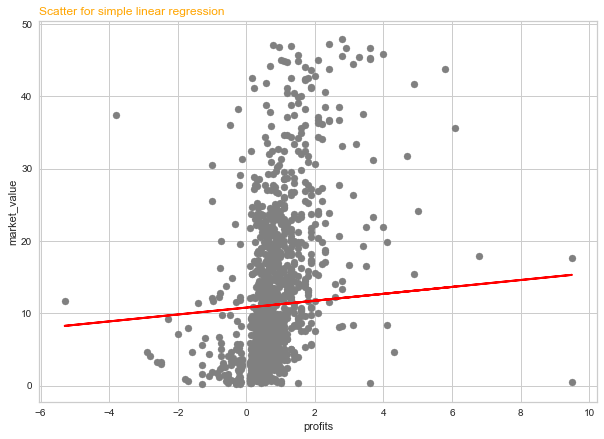

In [19]:
fig = plt.figure(figsize = (10, 7))

plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.title(
    f'Scatter for simple linear regression',
    loc='left',
    fontsize=12,
    fontweight=0,
    color='orange'
)
plt.xlabel('profits')
plt.ylabel('market_value')
plt.show()

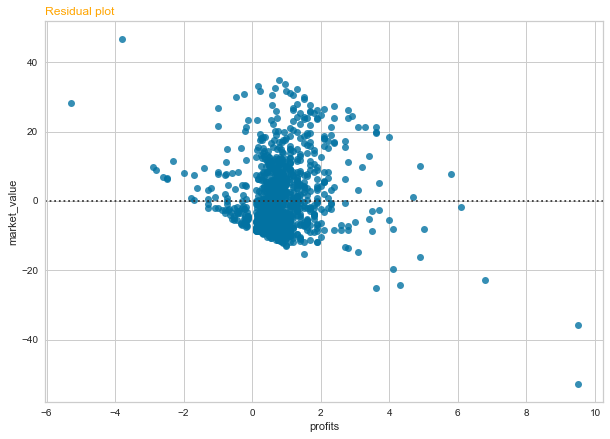

In [20]:
fig = plt.figure(figsize = (10, 7))
sns.residplot(X_test, y_test)

# title and labels
plt.title(
    'Residual plot',
    loc='left',
    fontsize=12,
    fontweight=0,
    color='orange'
)
plt.xlabel('profits')
plt.ylabel('market_value')
plt.show()

In [21]:
# Durbin-Watson test to test if errors are independent

sms.stattools.durbin_watson(lm_wrapper.residuals())

1.2338177488335582

In [ ]:
# Given the statistical value of 1.233,
# the test does not provides evidence that there is no serial correlation present
# meaning the residual error terms might be correlated and might not be independent

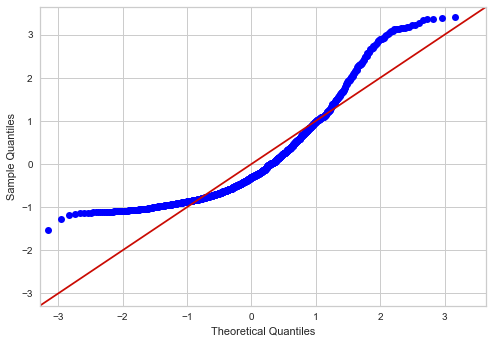

In [22]:
sm.qqplot(lm_wrapper.residuals(), stats.norm, fit=True, line="45")
plt.show()

In [23]:
lm_wrapper.print()

R2 Square: 0.02494391020546083
Mean Absolute Error: 7.850809204799746
Mean Squared Error: 106.7989714963317
Root Mean Squared Error: 10.334358784962506


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15496 entries, 0 to 15495
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       15496 non-null  object 
 1   industry      15496 non-null  object 
 2   sector        15496 non-null  object 
 3   country       15496 non-null  object 
 4   continent     15496 non-null  object 
 5   market_value  15496 non-null  float64
 6   profits       15496 non-null  float64
 7   assets        15496 non-null  float64
 8   sales         15496 non-null  float64
 9   cost          15496 non-null  float64
 10  rank          15496 non-null  int64  
 11  year          15496 non-null  int64  
 12  test          15496 non-null  bool   
dtypes: bool(1), float64(5), int64(2), object(5)
memory usage: 1.4+ MB


In [25]:
industry_dummies = pd.get_dummies(df.industry, prefix='industry')
sector_dummies = pd.get_dummies(df.sector, prefix='sector')
continent_dummies = pd.get_dummies(df.continent, prefix='continent')
country_dummies = pd.get_dummies(df.country, prefix='country')

df = pd.concat(
    [df,industry_dummies,sector_dummies,continent_dummies,country_dummies],
    axis=1
)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15496 entries, 0 to 15495
Columns: 188 entries, company to country_vietnam
dtypes: bool(1), float64(5), int64(2), object(5), uint8(175)
memory usage: 4.0+ MB


In [27]:
np.quantile(
    df['rank'],
    [0.2,0.4,0.6,0.8]
)

array([ 713., 1042., 1351., 1666.])

In [31]:
# MULTIPLE LINEAR REGRESSION

x=df.drop(['company','market_value','year','industry','sector','country','continent'], axis=1)

In [33]:
def get_selected_variance_df(df: pd.DataFrame, threshold: float):
    print(f'threshold -> {threshold}')
    thresholder = VarianceThreshold(threshold=threshold)

    thresholder.fit(df)
    mask = thresholder.get_support()
    new_df = df.loc[:,mask]
    print(f'features -> {len(new_df.columns)}')
    return new_df


def test_variance_df(x_df: pd.DataFrame, y_df: pd.DataFrame):
    X_train, X_test, y_train, y_test = train_test_split_by_year(x_df, y_df)

    # Init, fit, score
    forest = RandomForestRegressor(random_state=RANDOM_SEED)

    forest.fit(X_train, y_train)

    train_score = forest.score(X_train, y_train)
    test_score = forest.score(X_test, y_test)

    return {
        'train_score': train_score,
        'test_score': test_score
    }

In [39]:
scores=[]
for threshold in [1,.03,.02,.01,.008,.005]:
    print('Feature Variance Test')
    print('---------------------')
    variance_features = get_selected_variance_df(
        df=x.drop('test', axis=1),
        threshold=threshold
    ).columns

    features = ['test']
    for feature in variance_features:
        features.append(feature)

    regressor_score = test_variance_df(
        x_df=x.loc[:,features],
        y_df=y
    )

    print(f"train: {regressor_score['train_score']}")
    print(f"test {regressor_score['test_score']}")
    scores.append(regressor_score)
    print('\n')


Feature Variance Test
---------------------
threshold -> 1
features -> 5
train: 0.9516401847367296
test 0.7254098340894937


Feature Variance Test
---------------------
threshold -> 0.03
features -> 27
train: 0.9589742000590036
test 0.7466130815878278


Feature Variance Test
---------------------
threshold -> 0.02
features -> 42
train: 0.9601170945434823
test 0.750252972118073


Feature Variance Test
---------------------
threshold -> 0.01
features -> 75
train: 0.9613173149771527
test 0.7594617922385684


Feature Variance Test
---------------------
threshold -> 0.008
features -> 86
train: 0.9614921705289933
test 0.762308443477884


Feature Variance Test
---------------------
threshold -> 0.005
features -> 108
train: 0.9624231211655729
test 0.7618157398303134




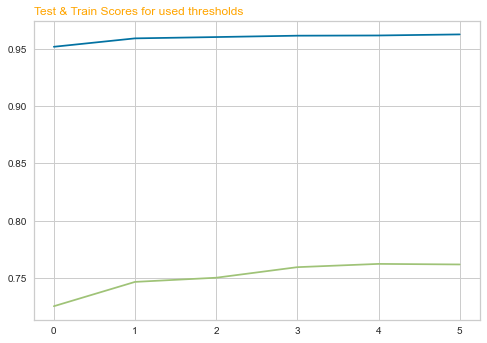

In [40]:
df_scores=pd.DataFrame(scores)

plt.plot(df_scores.train_score)
plt.plot(df_scores.test_score)
plt.title(
    f'Test & Train Scores for used thresholds',
    loc='left',
    fontsize=12,
    fontweight=0,
    color='orange'
)
plt.show()

In [ ]:
# From a Variance Threshold point of view,
# best result would be to use 0.01 threshold
# which involves 27 variables for linear regression model

In [41]:
variance_features = get_selected_variance_df(
    df=x.drop('test', axis=1),
    threshold=.01
).columns

features = ['test']
for feature in variance_features:
    features.append(feature)

threshold -> 0.01
features -> 75


In [42]:
x=x.loc[:, features]

X_train, X_test, y_train, y_test = train_test_split_by_year(x, y)

mlr_model = LinearRegression().fit(X_train, y_train)

In [43]:
# Print the Intercept:
print('intercept:', mlr_model.intercept_)

# Print the Slope:
coeff_df = pd.DataFrame(
    lzip(x.columns,mlr_model.coef_),
    columns=['variable','value']
)
coeff_df

intercept: 79069451.02574737


,variable,value
0,test,-21.316059
1,profits,0.013541
2,assets,21.148236
3,sales,-21.231452
4,cost,-0.012850
...,...,...
70,country_south_korea,1.391369
71,country_sweden,2.784166
72,country_switzerland,-1.216378
73,country_taiwan,1.486994


In [44]:
y_pred = mlr_model.predict(X_test)

mlr_wrapper = ResultWrapper(
    y_test=y_test,
    y_pred=y_pred
)

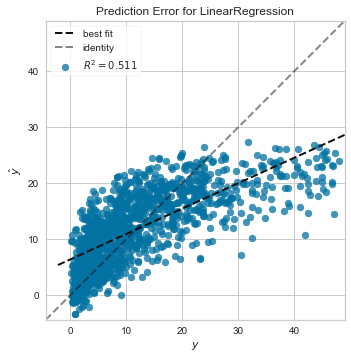

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=LinearRegression())

In [45]:
# Making the Prediction Error Plot
prediction_error(mlr_model, X_train, y_train, X_test, y_test)

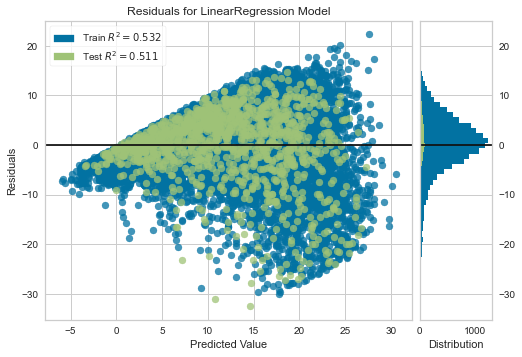

AttributeError: 'LinearRegression' object has no attribute 'line_color'

AttributeError: 'LinearRegression' object has no attribute 'line_color'

In [46]:
# Making the Residuals Plot
residuals_plot(mlr_model, X_train, y_train, X_test, y_test)

In [47]:
mlr_results = pd.DataFrame({'actual': y_test, 'prediction': y_pred})
mlr_results['residuals'] = mlr_wrapper.residuals()
mlr_results

,actual,prediction,residuals
0,35.6,23.970890,11.629110
1,45.5,24.136628,21.363372
2,45.2,19.017938,26.182062
3,45.3,25.396124,19.903876
4,37.5,24.198400,13.301600
...,...,...,...
1267,5.0,2.428193,2.571807
1268,3.3,3.038155,0.261845
1269,6.9,4.188136,2.711864
1270,8.3,1.740945,6.559055


In [48]:
# Durbin-Watson test to test if errors are independent

sms.stattools.durbin_watson(mlr_wrapper.residuals())

1.805288072024822

In [ ]:
# Given the statistical value of 1.805,
# the test provides evidence that there is no serial correlation present
# meaning the residual error terms are uncorrelated and are independent

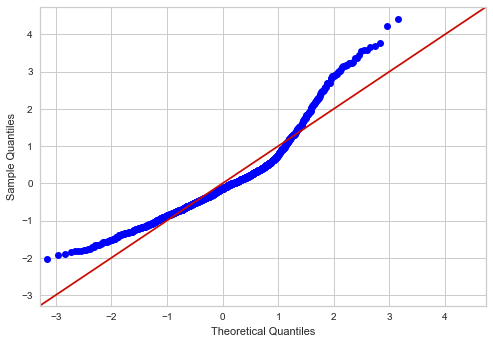

In [49]:
sm.qqplot(mlr_wrapper.residuals(), stats.norm, fit=True, line="45")
plt.show()

In [50]:
mlr_wrapper.print()

R2 Square: 0.5114878364846357
Mean Absolute Error: 5.305205606968897
Mean Squared Error: 53.50727734840604
Root Mean Squared Error: 7.314866871543599


In [51]:
# DECISION TREES & RANDOM FOREST
x=df.drop(['company','market_value','year','industry','sector','country','continent'], axis=1)

X_train, X_test, y_train, y_test = train_test_split_by_year(x, y)

In [52]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)


In [53]:
tree_model = DecisionTreeRegressor(
    random_state=RANDOM_SEED
)

tree_model.fit(train_scaled, y_train)

y_pred = tree_model.predict(test_scaled)

In [54]:
tree_wrapper = ResultWrapper(
    y_test=y_test,
    y_pred=y_pred
)

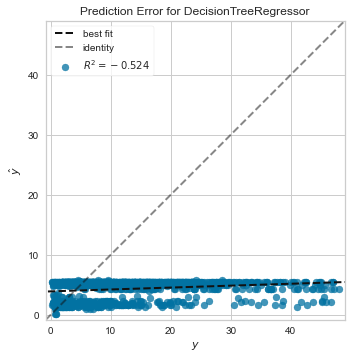

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=DecisionTreeRegressor(random_state=671993))

In [55]:
# Making the Prediction Error Plot
prediction_error(tree_model, X_train, y_train, X_test, y_test)

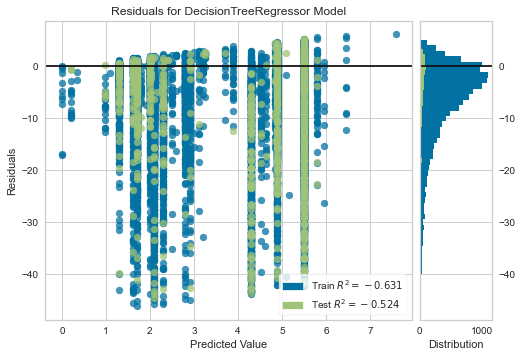

AttributeError: 'DecisionTreeRegressor' object has no attribute 'line_color'

AttributeError: 'DecisionTreeRegressor' object has no attribute 'line_color'

In [56]:
# Making the Residuals Plot
residuals_plot(tree_model, X_train, y_train, X_test, y_test)

In [57]:
tree_results = pd.DataFrame({'actual': y_test, 'prediction': y_pred})
tree_results['residuals'] = tree_wrapper.residuals()
tree_results

,actual,prediction,residuals
0,35.6,28.190,7.410
1,45.5,31.130,14.370
2,45.2,35.950,9.250
3,45.3,46.360,-1.060
4,37.5,35.950,1.550
...,...,...,...
1267,5.0,5.684,-0.684
1268,3.3,4.400,-1.100
1269,6.9,1.986,4.914
1270,8.3,5.816,2.484


In [58]:
# Durbin-Watson test to test if errors are independent

sms.stattools.durbin_watson(tree_wrapper.residuals())

1.9683273817191633

In [ ]:
# Given the statistical value of 1.968,
# the test provides evidence that there is no serial correlation present
# meaning the residual error terms are uncorrelated and are independent

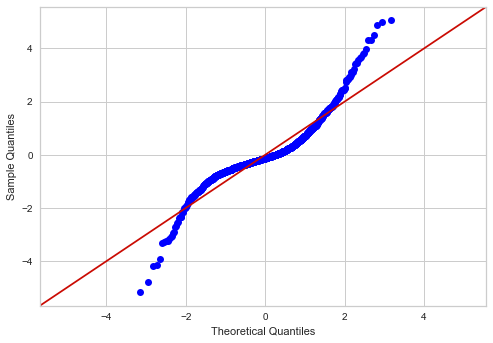

In [59]:
sm.qqplot(tree_wrapper.residuals(), stats.norm, fit=True, line="45")
plt.show()

In [60]:
tree_wrapper.print()

R2 Square: 0.6015284683751003
Mean Absolute Error: 4.243007075471698
Mean Squared Error: 43.645027392295596
Root Mean Squared Error: 6.606438328804379


In [61]:
rf_model = RandomForestRegressor(
    random_state=RANDOM_SEED
)

rf_model.fit(train_scaled, y_train)

y_pred = rf_model.predict(test_scaled)

In [62]:
rf_wrapper = ResultWrapper(
    y_test=y_test,
    y_pred=y_pred
)

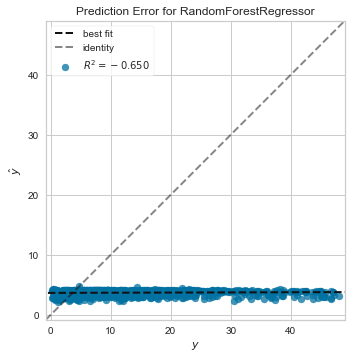

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=RandomForestRegressor(random_state=671993))

In [63]:
# Making the Prediction Error Plot
prediction_error(rf_model, X_train, y_train, X_test, y_test)

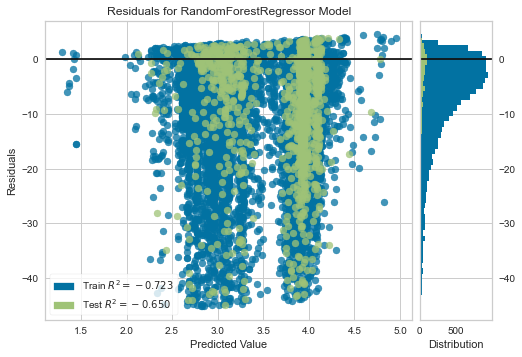

AttributeError: 'RandomForestRegressor' object has no attribute 'line_color'

AttributeError: 'RandomForestRegressor' object has no attribute 'line_color'

In [64]:
# Making the Residuals Plot
residuals_plot(rf_model, X_train, y_train, X_test, y_test)

In [65]:
rf_results = pd.DataFrame({'actual': y_test, 'prediction': y_pred})
rf_results['residuals'] = rf_wrapper.residuals()
rf_results

,actual,prediction,residuals
0,35.6,36.80498,-1.20498
1,45.5,36.83045,8.66955
2,45.2,34.77453,10.42547
3,45.3,36.05277,9.24723
4,37.5,34.77221,2.72779
...,...,...,...
1267,5.0,4.25871,0.74129
1268,3.3,3.43130,-0.13130
1269,6.9,7.01955,-0.11955
1270,8.3,6.97853,1.32147


In [66]:
# Durbin-Watson test to test if errors are independent

sms.stattools.durbin_watson(rf_wrapper.residuals())

1.89814823817806

In [ ]:
# Given the statistical value of 1.898,
# the test provides evidence that there is no serial correlation present
# meaning the residual error terms are uncorrelated and are independent

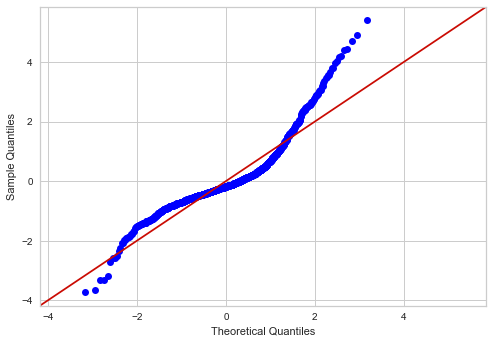

In [67]:
sm.qqplot(rf_wrapper.residuals(), stats.norm, fit=True, line="45")
plt.show()

In [68]:
rf_wrapper.print()

R2 Square: 0.7653840497225782
Mean Absolute Error: 3.3101192374213837
Mean Squared Error: 25.69774441544488
Root Mean Squared Error: 5.069294271932226


In [69]:
# XGBOOST MODEL
x=df.drop(['company','market_value','year','industry','sector','country','continent'], axis=1)

X_train, X_test, y_train, y_test = train_test_split_by_year(x, y)

In [71]:
# Instantiate an XGBoost object with hyperparameters
xgb_reg = xgb.XGBRegressor(
    max_depth=3,
    n_estimators=100,
    n_jobs=2,
    objective='reg:squarederror',
    booster='gbtree',
    random_state=RANDOM_SEED,
    learning_rate=0.05
)

# Train the model with train data sets
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test) # Predictions

In [72]:
xg_wrapper = ResultWrapper(
    y_test=y_test,
    y_pred=y_pred
)

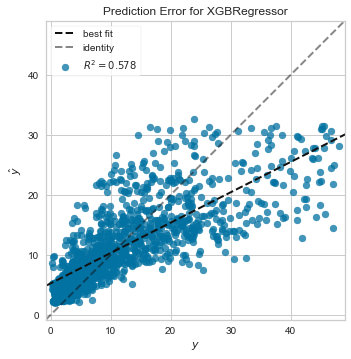

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.05, max_delta_step=0,
                                       max_depth=3, min_child_weight=1,
                                       missing=nan, monotone_constraints='()',
                                       n_estimators=100, n_jobs=2,
                                       num_parallel_tree=1, random_state=671993,
                                       reg_alpha=0, reg_lambda=1,
                                       scale_pos_weight=1, subsample=1,
  

In [73]:
# Making the Prediction Error Plot
prediction_error(xgb_reg, X_train, y_train, X_test, y_test)

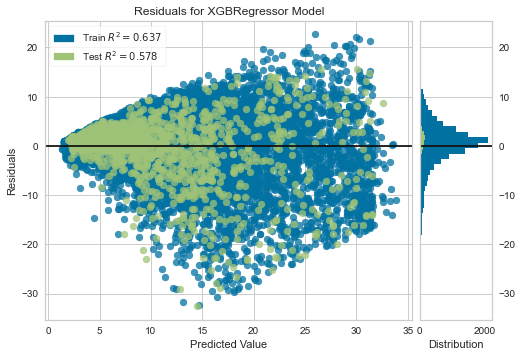

AttributeError: 'XGBRegressor' object has no attribute 'line_color'

AttributeError: 'XGBRegressor' object has no attribute 'line_color'

In [74]:
# Making the Residuals Plot
residuals_plot(xgb_reg, X_train, y_train, X_test, y_test)

In [75]:
xg_results = pd.DataFrame({'actual': y_test, 'prediction': y_pred})
xg_results['residuals'] = xg_wrapper.residuals()
xg_results

,actual,prediction,residuals
0,35.6,30.392614,5.207386
1,45.5,31.484951,14.015049
2,45.2,30.956825,14.243175
3,45.3,31.484951,13.815049
4,37.5,31.484951,6.015049
...,...,...,...
1267,5.0,3.826935,1.173065
1268,3.3,4.657328,-1.357328
1269,6.9,7.809474,-0.909474
1270,8.3,4.964634,3.335366


In [76]:
# Durbin-Watson test to test if errors are independent

sms.stattools.durbin_watson(xg_wrapper.residuals())

1.932151023247158

In [ ]:
# Given the statistical value of 1.932,
# the test provides evidence that there is no serial correlation present
# meaning the residual error terms are uncorrelated and are independent

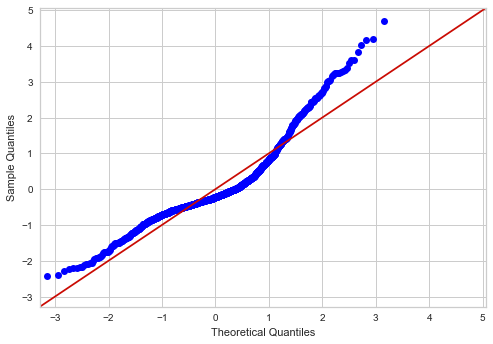

In [77]:
sm.qqplot(xg_wrapper.residuals(), stats.norm, fit=True, line="45")
plt.show()

In [ ]:
xg_wrapper.print()

In [ ]:
print('TEST RESULTS')

In [ ]:
lm_wrapper.print()

In [ ]:
mlr_wrapper.print()

In [ ]:
tree_wrapper.print()

In [ ]:
rf_wrapper.print()

In [ ]:
xg_wrapper.print()

In [ ]:
for lambda_value in [1, 10, 50, 100]:
    # Instantiate an XGBoost object with hyperparameters
    xgb_reg = xgb.XGBRegressor(
        max_depth=3,
        n_estimators=100,
        n_jobs=2,
        objectvie='reg:squarederror',
        booster='gbtree',
        random_state=RANDOM_SEED,
        learning_rate=0.05,
        reg_lambda=lambda_value
    )

    # Train the model with train data sets
    xgb_reg.fit(X_train, y_train)

    y_pred = xgb_reg.predict(X_test)

    wrapper = ResultWrapper(
        y_test=y_test,
        y_pred=y_pred
    )
    print(f'REG LAMBDA {lambda_value}')
    print('--------------------------')
    wrapper.print()
    print('\n')